In [1]:
# run this cell only once

import os
import sys

# activate virtual environment. If you don't have one, create it first.
# !venv\Scripts\activate

# Clone only one time the ritm repo. If you already have it, comment this line.
!git clone https://github.com/uncbiag/SimpleClick.git
os.chdir('SimpleClick') 
sys.path.insert(0, '..') # allow you to import modules from ritm repo
!pip install -r requirements.txt
!pip install torch torchvision torchaudio cudatoolkit=11.3 -f https://download.pytorch.org/whl/torch_stable.html

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
from isegm.inference.predictors import get_predictor
from isegm.inference.clicker import Click, Clicker
from isegm.utils import vis, exp
from isegm.inference import utils
cfg = exp.load_config_file('config.yml', return_edict=True)

## Here we load the model. You can use any model from the ritm repo.
weights_path = 'cocolvis_vit_base.pth'
MODEL_THRESH = 0.50

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, weights_path)
model = utils.load_is_model(checkpoint_path, device, eval_ritm=False)

# For our purposes, we don't need to use the BRS mode.
brs_mode = 'NoBRS'
simple_predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

c:\Users\Vítor\Documents\GitHub\vdj_grape_annotation\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ImageAnnotations is the class that will help us to load the annotations from diverse formats and work simultaneously with multiple annotations. 
# Some caracteristics of the class:
# - It can load annotations from Supervisely*, wgisd and can easly be extended to other formats.
# - It can load multiple annotations from different formats
import numpy as np
from modules.dataset import ImageAnnotations
from copy import copy
from PIL import Image

def create_clicker_from_annotations(annotation:ImageAnnotations, bbox_id:int, include_aux=True, scale_y=1, scale_x=1):
    """Create a clicker object from an annotation object."""
    clicker = Clicker()
    bbox = next(box for box in annotation.box_annotations if box['id'] == annotation.box_annotations[bbox_id]['id'])
    
    for point_id in bbox['points_inside']:
        point = next(p for p in annotation.point_annotations if p['id'] == point_id)
        aux_points = []
        if point['is_aux']:
            aux_points.append(point)
        else:
            click = Click(is_positive=point['is_positive'], coords=[point['coord_bb'][1], point['coord_bb'][0]])
            click.coords[0] = int(click.coords[0] * scale_y)
            click.coords[1] = int(click.coords[1] * scale_x)
            clicker.add_click(click)
        if include_aux and aux_points:
            for aux_point in aux_points:
                click = Click(is_positive=aux_point['is_positive'], coords=[aux_point['coord_bb'][1], aux_point['coord_bb'][0]])
                click.coords[0] = int(click.coords[0] * scale_y)
                click.coords[1] = int(click.coords[1] * scale_x)
                clicker.add_click(click)
    return clicker

def get_simpleclick_prediction(simple_predictor, annotations:ImageAnnotations, jsons_folder='../datasets/supervisely_annotations/'
                        , wgisd_folder='../datasets/wgisd_annotations/', include_aux=True, wgisd_n_points=3):
    """Finally, we can get the RITM prediction for a given image."""
    annotations.load_image('../datasets/images/' + annotations.image_name)
    simple_predictor = copy(simple_predictor) # If your wanna make sure one prediction doesn't affect the other
    if annotations.image_name.startswith('DSC'):
        annotations.read_supervisely(jsons_folder + annotations.image_name + '.json')
        annotations.validate_supervisely_annotations()
    elif annotations.image_name.startswith('SYH') or annotations.image_name.startswith('CSV'):
        sufx = f'-{wgisd_n_points}point' if wgisd_n_points==1 else f'-{wgisd_n_points}points'
        annotations.read_wgisd(wgisd_folder + annotations.image_name.replace('.jpg', '.npz'), excel_sufx=sufx)
    
    ritm_predictions = []
    for id, bb in enumerate(annotations.box_annotations):
        print(bb)
        image = annotations.bb_image_2_np(bb)
        resized_image, scale_y, scale_x = resize_and_pad_image(image)
        simple_predictor.set_input_image(resized_image)
        clicker = create_clicker_from_annotations(annotations, id, include_aux=include_aux, scale_y=scale_y, scale_x=scale_x)
        pred = simple_predictor.get_prediction(clicker)
        ritm_predictions.append(pred)
    return ritm_predictions, clicker

def pad_to_multiple(image, multiple=16):
    height, width = image.shape[:2]
    pad_height = (multiple - height % multiple) % multiple
    pad_width = (multiple - width % multiple) % multiple

    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
    return padded_image

def resize_and_pad_image(image, target_size=(448, 448), multiple=16):
    # Ensure the target size is a multiple of 16
    target_height = (target_size[0] // multiple) * multiple
    target_width = (target_size[1] // multiple) * multiple
    
    pil_image = Image.fromarray(image)
    resized_image = pil_image.resize((target_width, target_height), Image.BILINEAR)
    resized_image = np.array(resized_image)
    padded_image = pad_to_multiple(resized_image, multiple)
    return padded_image

{'class': 'caixa', 'coords': [[1862, 2530], [2397, 2870]], 'id': 0, 'points_inside': [30, 31, 32]}
(448, 448, 3)


c:\Users\Vítor\Documents\GitHub\vdj_grape_annotation\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


x shape: torch.Size([2, 3, 448, 448])
x shape after patch_embed: torch.Size([2, 784, 768])
pos_embed shape: torch.Size([1, 784, 768])
{'class': 'caixa', 'coords': [[1866, 2113], [2305, 2535]], 'id': 1, 'points_inside': [33, 34, 35]}
(448, 448, 3)
x shape: torch.Size([2, 3, 448, 448])
x shape after patch_embed: torch.Size([2, 784, 768])
pos_embed shape: torch.Size([1, 784, 768])
{'class': 'caixa', 'coords': [[1603, 2094], [1870, 2619]], 'id': 2, 'points_inside': [21, 22, 23]}
(448, 448, 3)
x shape: torch.Size([2, 3, 448, 448])
x shape after patch_embed: torch.Size([2, 784, 768])
pos_embed shape: torch.Size([1, 784, 768])
{'class': 'caixa', 'coords': [[904, 2266], [1132, 2675]], 'id': 3, 'points_inside': [12, 13, 14]}
(448, 448, 3)
x shape: torch.Size([2, 3, 448, 448])
x shape after patch_embed: torch.Size([2, 784, 768])
pos_embed shape: torch.Size([1, 784, 768])
{'class': 'caixa', 'coords': [[754, 1886], [941, 2024]], 'id': 4, 'points_inside': [9, 10, 11]}
(448, 448, 3)
x shape: torch.S

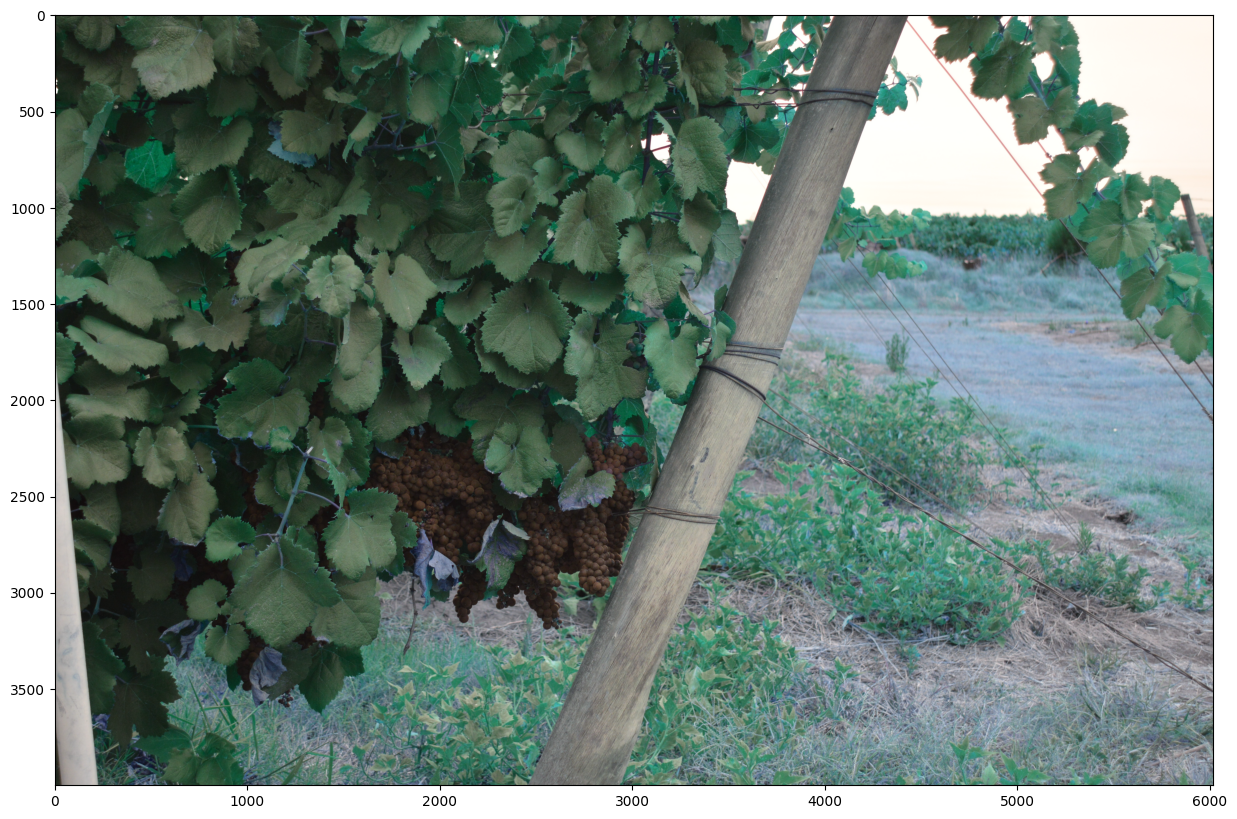

In [4]:
import matplotlib.pyplot as plt
import numpy as np

jpg_file = 'DSC_0152.JPG'
# jpg_file = 'CSV_1865.jpg'

# Enable predictor
anot = ImageAnnotations(jpg_file)
simple_predictions, clicker = get_simpleclick_prediction(simple_predictor, anot, include_aux=True)

prediction_label = f'simpleclick_{brs_mode}_3_points' # file suffix and predictions dictionary key
anot.reconstruct_prediction_mask(simple_predictions, prediction_label)
plt.rcParams["figure.figsize"] = (30,10)
plt.imshow(anot.image_pred[prediction_label] >= 0.5)
plt.imshow(anot.image, cmap='magma')

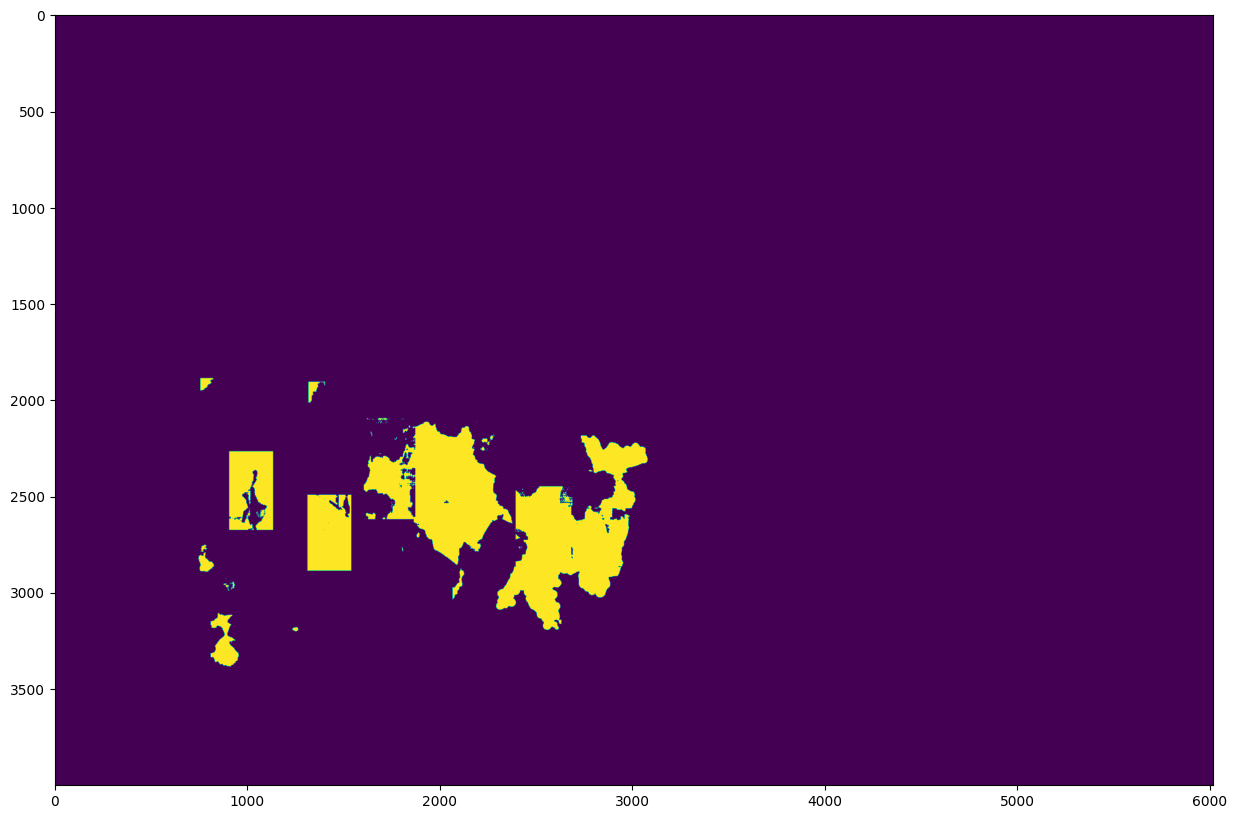

In [10]:
plt.rcParams["figure.figsize"] = (30,10)
plt.imshow(anot.image_pred[prediction_label] >= 0.5)
# plt.imshow(anot.image, cmap='plasma')

In [6]:
anot.image.shape, anot.image_pred.keys()

((4000, 6016, 3), dict_keys(['simpleclick_NoBRS_3_points']))